<h1 style="background-color:rgb(21, 131, 85); font-family: newtimeroman; font-size: 250%; color: white; border-radius: 80px 20px; padding: 25px; text-align: center;">
<b>Potato Disease Leaf Dataset(PLD)</b>
</h1>

**Objective**

- Develop a multi-level deep learning model for potato leaf disease detection. <br>
0 : early blight <br>
1 : healthy <br>
2 : late blight <br>

-  Class Descriptions

1) Early Blight
A fungal disease caused by Alternaria solani. It appears as dark spots with concentric rings on older leaves. If untreated, it can spread and reduce crop yield.

2) Healthy
Leaves show no signs of disease—they appear green and uniform with no spots, discoloration, or visible damage.

3) Late Blight
Caused by Phytophthora infestans, this is a serious disease that spreads quickly. Symptoms include brown or black lesions with yellow edges, especially in humid conditions.

-Dataset link : https://www.kaggle.com/datasets/rizwan123456789/potato-disease-leaf-datasetpld/data



# `00` **Import used libraries**

In [ ]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications import MobileNetV2
from keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout , Flatten, GlobalAveragePooling2D , Conv2D , MaxPooling2D , BatchNormalization
from tensorflow.keras.models import Model

tf.random.set_seed(1234)


# `01` **Load Dataset**

## **Set Global Parameters**

In [ ]:
batch_size  = 32
epochs     = 100
image_size = (224, 224)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [ ]:
!kaggle datasets download -d rizwan123456789/potato-disease-leaf-datasetpld

Dataset URL: https://www.kaggle.com/datasets/rizwan123456789/potato-disease-leaf-datasetpld
License(s): DbCL-1.0


In [ ]:
!unzip -q potato-disease-leaf-datasetpld.zip

In [ ]:
train_path = os.path.join("PLD_3_Classes_256", "Training")
validation_path = os.path.join("PLD_3_Classes_256", "Validation")
test_path = os.path.join("PLD_3_Classes_256", "Testing")

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_path,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=validation_path,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_path,
    batch_size=batch_size,
    image_size=image_size,
)

Found 3251 files belonging to 3 classes.
Found 416 files belonging to 3 classes.
Found 405 files belonging to 3 classes.


## **Class names**

In [ ]:
class_names = train_data.class_names
print("Class names:", class_names)

Class names: ['Early_Blight', 'Healthy', 'Late_Blight']


## **Show some data images**

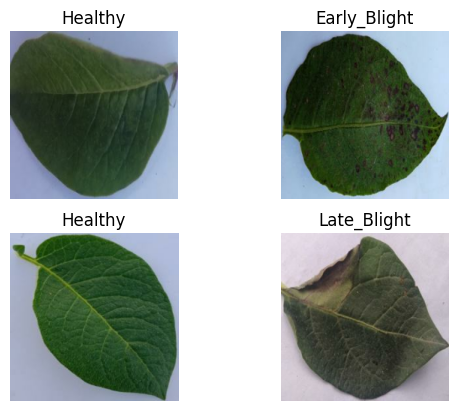

In [ ]:
x, y = next(train_data.as_numpy_iterator())
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(x[i].astype("uint8"))
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.show()

## **ImageGenerator**

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
    )

train_scaled_data = datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)
valid_scaled_data = datagen.flow_from_directory(
    validation_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 3251 images belonging to 3 classes.
Found 416 images belonging to 3 classes.


In [ ]:
test_data = test_data.map(lambda x, y: (x / 255.0, y))

In [ ]:
train_scaled_data.class_indices

{'Early_Blight': 0, 'Healthy': 1, 'Late_Blight': 2}

# `02` **Modelling**





## `i` **Model Design**
- **CNN from Scratch**

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',padding='same',input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same',strides=2))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same',strides=2))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,584,259 (55.63 MB)

 Trainable params: 14,581,507 (55.62 MB)

 Non-trainable params: 2,752 (10.75 KB)

## `ii` Model Compilation & Training

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(train_scaled_data,validation_data=valid_scaled_data, epochs=epochs, batch_size=batch_size, callbacks=[early_stop], verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 65s 512ms/step - accuracy: 0.5258 - loss: 1.0675 - val_accuracy: 0.2452 - val_loss: 8.0706
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 483ms/step - accuracy: 0.7031 - loss: 0.7030 - val_accuracy: 0.2452 - val_loss: 6.1473
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 45s 437ms/step - accuracy: 0.8005 - loss: 0.5235 - val_accuracy: 0.2452 - val_loss: 9.4027
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 428ms/step - accuracy: 0.8461 - loss: 0.4034 - val_accuracy: 0.2716 - val_loss: 3.6598
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 435ms/step - accuracy: 0.8786 - loss: 0.3180 - val_accuracy: 0.3534 - val_loss: 2.2649
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 434ms/step - accuracy: 0.8838 - loss: 0.3202 - val_accuracy: 0.6779 - val_loss: 1.1064
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 95s 559ms/step - accuracy: 0.9164 - loss: 0.2236 - val_accuracy: 0.8606 - val_loss: 0.3612
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 47s 462ms/step - accuracy: 0.9183 -

## `iii` Model Evaluation

In [ ]:
loss, accuracy = model.evaluate(test_data)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.9640 - loss: 0.1261
Loss: 0.15202608704566956
Accuracy: 0.9580246806144714


## `iv` Result Visualization

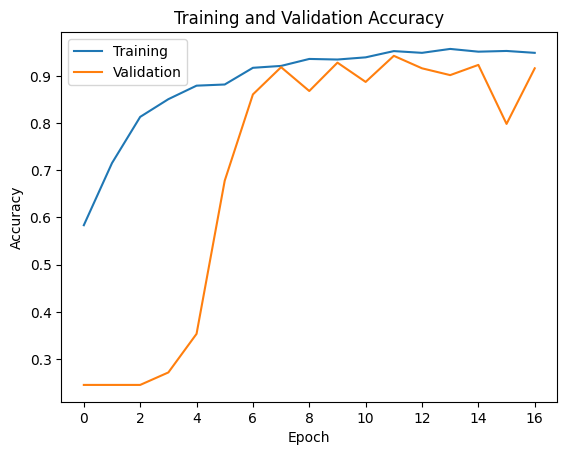

In [ ]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

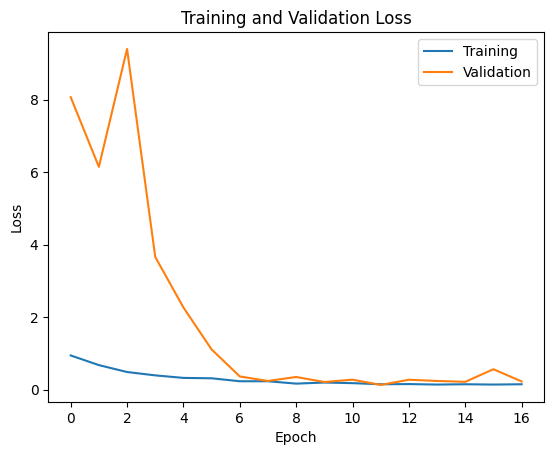

In [ ]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## **Testing model**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


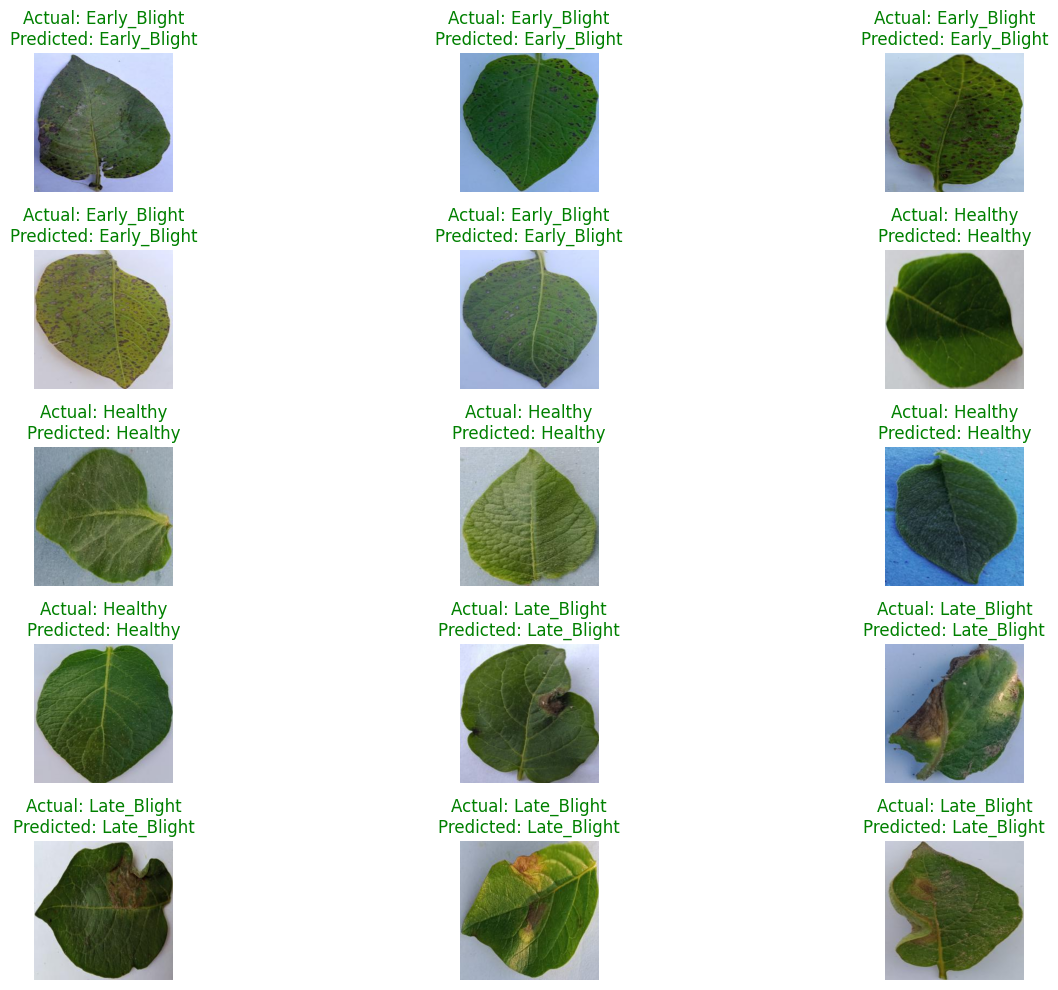

In [ ]:
model_test = model
dataset_path = "/content/PLD_3_Classes_256/Testing"
class_labels = ["Early_Blight", "Healthy", "Late_Blight"]

def preprocess_image(image_path, target_size=(224, 224)):
    try:
        img = image.load_img(image_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        return img_array
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

def predict_image(image_path):
    img_array = preprocess_image(image_path)
    if img_array is None:
        return "Unreadable"

    prediction = model_test.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    return class_labels[predicted_class]

selected_images = []
actual_labels = []

for class_name in class_labels:
    class_dir = os.path.join(dataset_path, class_name)

    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if len(images) < 5:
        print(f"Warning: Only {len(images)} images found in {class_name}, using all available images.")

    selected_images.extend(random.sample(images, min(5, len(images))))
    actual_labels.extend([class_name] * min(5, len(images)))

plt.figure(figsize=(15, 10))

for i, img_path in enumerate(selected_images):
    predicted_label = predict_image(img_path)

    try:

        img = image.load_img(img_path)
        plt.subplot(5, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        title_color = 'green' if predicted_label == actual_labels[i] else 'red'
        plt.title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_label}", color=title_color)

    except Exception as e:
        print(f"Error displaying image {img_path}: {e}")

plt.tight_layout()
plt.show()

## `i` **Model Design**
- **pretrained model (ResNet50)**

In [ ]:
image_input = Input(shape=(224, 224, 3))
base_model = ResNet50(input_tensor=image_input, include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(3, activation='softmax')(x)
premodel = Model(inputs=image_input, outputs=x)
premodel.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_80"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## `ii` Model Compilation & Training

In [ ]:
premodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = premodel.fit(train_scaled_data,validation_data=valid_scaled_data, epochs=epochs, batch_size=batch_size, callbacks=[early_stop], verbose=1)

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 67s 523ms/step - accuracy: 0.3566 - loss: 1.1298 - val_accuracy: 0.4471 - val_loss: 1.0638
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 45s 437ms/step - accuracy: 0.3873 - loss: 1.0689 - val_accuracy: 0.3918 - val_loss: 1.0644
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 433ms/step - accuracy: 0.3991 - loss: 1.0739 - val_accuracy: 0.4183 - val_loss: 1.0575
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 45s 439ms/step - accuracy: 0.4258 - loss: 1.0570 - val_accuracy: 0.4159 - val_loss: 1.0385
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 428ms/step - accuracy: 0.4431 - loss: 1.0380 - val_accuracy: 0.4423 - val_loss: 1.0115
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 45s 438ms/step - accuracy: 0.4506 - loss: 1.0222 - val_accuracy: 0.4808 - val_loss: 1.0130
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 45s 437ms/step - accuracy: 0.4587 - loss: 1.0134 - val_accuracy: 0.4399 - val_loss: 1.0092
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 432ms/step - accuracy: 0.4893 -

## `iii` Model Evaluation

In [ ]:
loss, accuracy = premodel.evaluate(test_data)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.4932 - loss: 0.9672
Loss: 0.9861384630203247
Accuracy: 0.48641976714134216


## `iv` Result Visualization

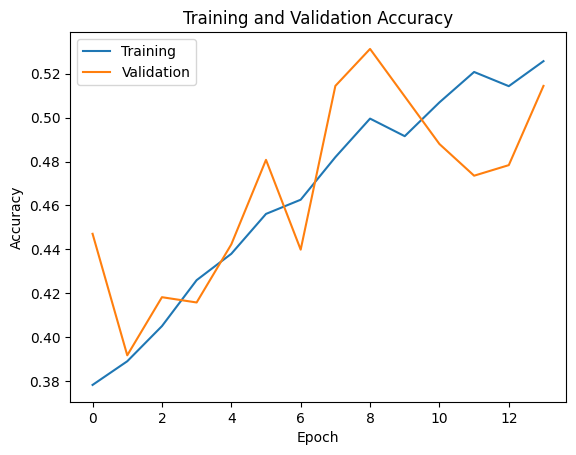

In [ ]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

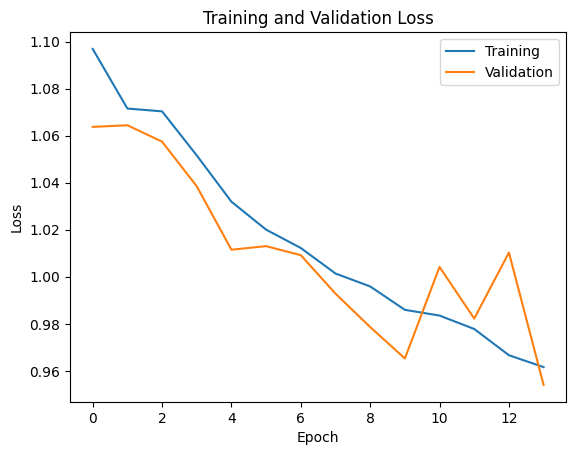

In [ ]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## **Testing pretrained model**

- Not best accuracy try another model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


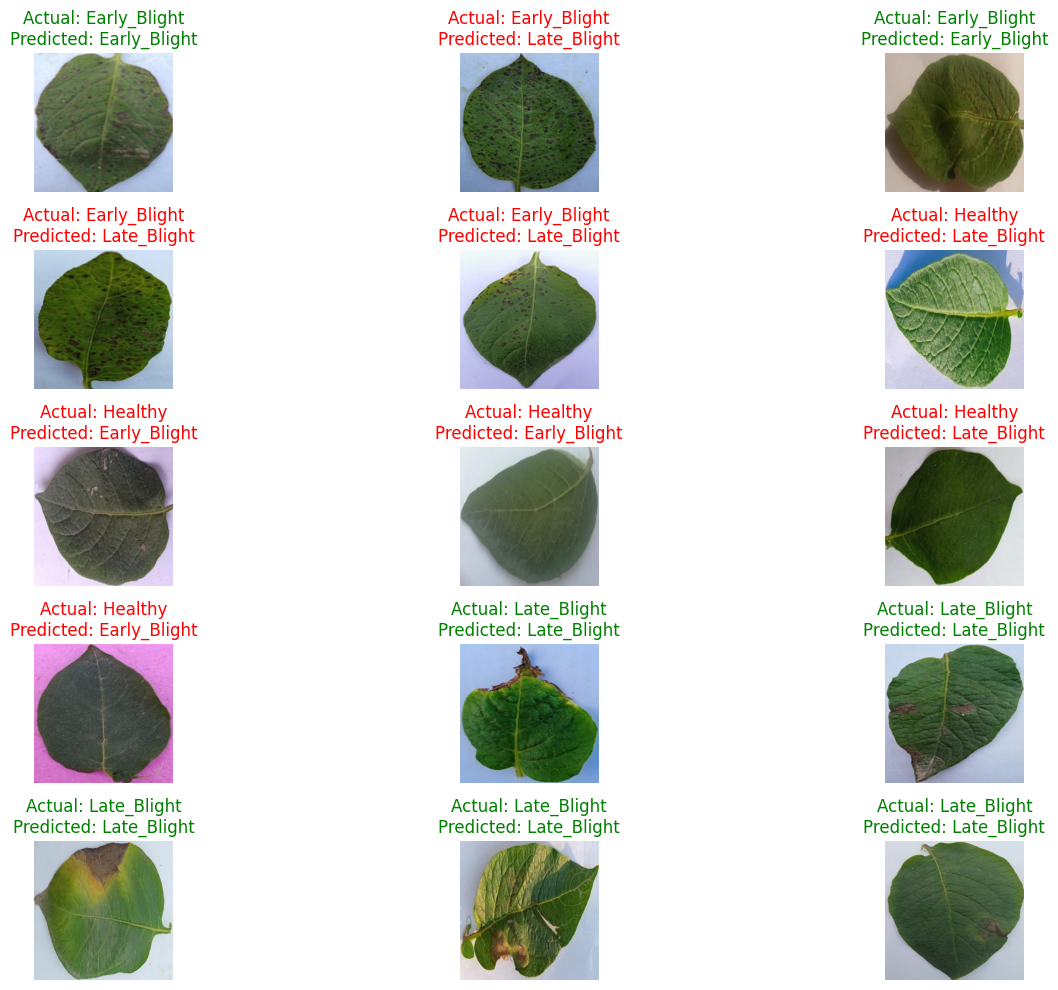

In [ ]:
model_test = premodel
dataset_path = "/content/PLD_3_Classes_256/Testing"
class_labels = ["Early_Blight", "Healthy", "Late_Blight"]

selected_images = []
actual_labels = []

for class_name in class_labels:
    class_dir = os.path.join(dataset_path, class_name)

    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if len(images) < 5:
        print(f"Warning: Only {len(images)} images found in {class_name}, using all available images.")

    selected_images.extend(random.sample(images, min(5, len(images))))
    actual_labels.extend([class_name] * min(5, len(images)))

plt.figure(figsize=(15, 10))

for i, img_path in enumerate(selected_images):
    predicted_label = predict_image(img_path)

    try:
        img = image.load_img(img_path)
        plt.subplot(5, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        title_color = 'green' if predicted_label == actual_labels[i] else 'red'
        plt.title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_label}", color=title_color)

    except Exception as e:
        print(f"Error displaying image {img_path}: {e}")

plt.tight_layout()
plt.show()

## `i` **Model Design**
- **pretrained model (MobileNetV2)**

In [ ]:
image_input = Input(shape=(224, 224, 3))
base_model = MobileNetV2(input_tensor=image_input, include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(3, activation='softmax')(x)
premodel = Model(inputs=image_input, outputs=x)
premodel.summary()

<ipython-input-52-d1382559e492>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=image_input, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## `ii` Model Compilation & Training

In [ ]:
premodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = premodel.fit(train_scaled_data,validation_data=valid_scaled_data, epochs=epochs, batch_size=batch_size, callbacks=[early_stop], verbose=1)

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 59s 485ms/step - accuracy: 0.7279 - loss: 0.6876 - val_accuracy: 0.9062 - val_loss: 0.2432
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 467ms/step - accuracy: 0.8937 - loss: 0.2759 - val_accuracy: 0.9327 - val_loss: 0.1860
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 413ms/step - accuracy: 0.9110 - loss: 0.2296 - val_accuracy: 0.9183 - val_loss: 0.2041
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 81s 408ms/step - accuracy: 0.9166 - loss: 0.2338 - val_accuracy: 0.9207 - val_loss: 0.1985
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 410ms/step - accuracy: 0.9213 - loss: 0.2005 - val_accuracy: 0.9327 - val_loss: 0.1897
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - accuracy: 0.9283 - loss: 0.2037 - val_accuracy: 0.9351 - val_loss: 0.1736
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 412ms/step - accuracy: 0.9402 - loss: 0.1680 - val_accuracy: 0.8846 - val_loss: 0.2861
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 404ms/step - accuracy: 0.9321 -

## `iii` Model Evaluation

In [ ]:
loss, accuracy = premodel.evaluate(test_data)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 274ms/step - accuracy: 0.9653 - loss: 0.1409
Loss: 0.1673671156167984
Accuracy: 0.9580246806144714


## `iv` Result Visualization

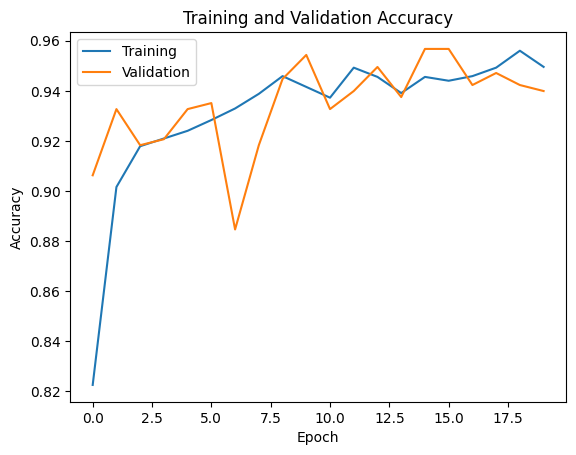

In [ ]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

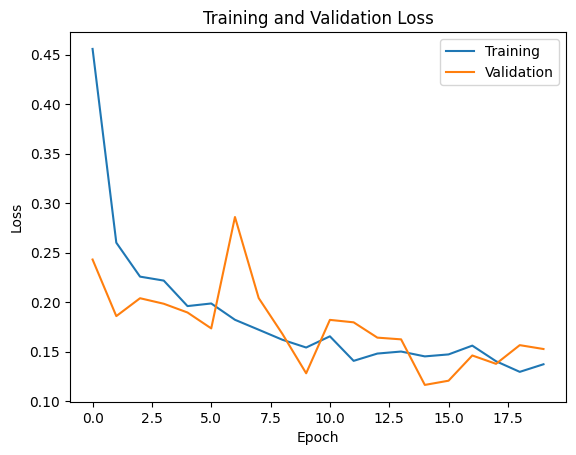

In [ ]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## **Testing pretrained model**

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


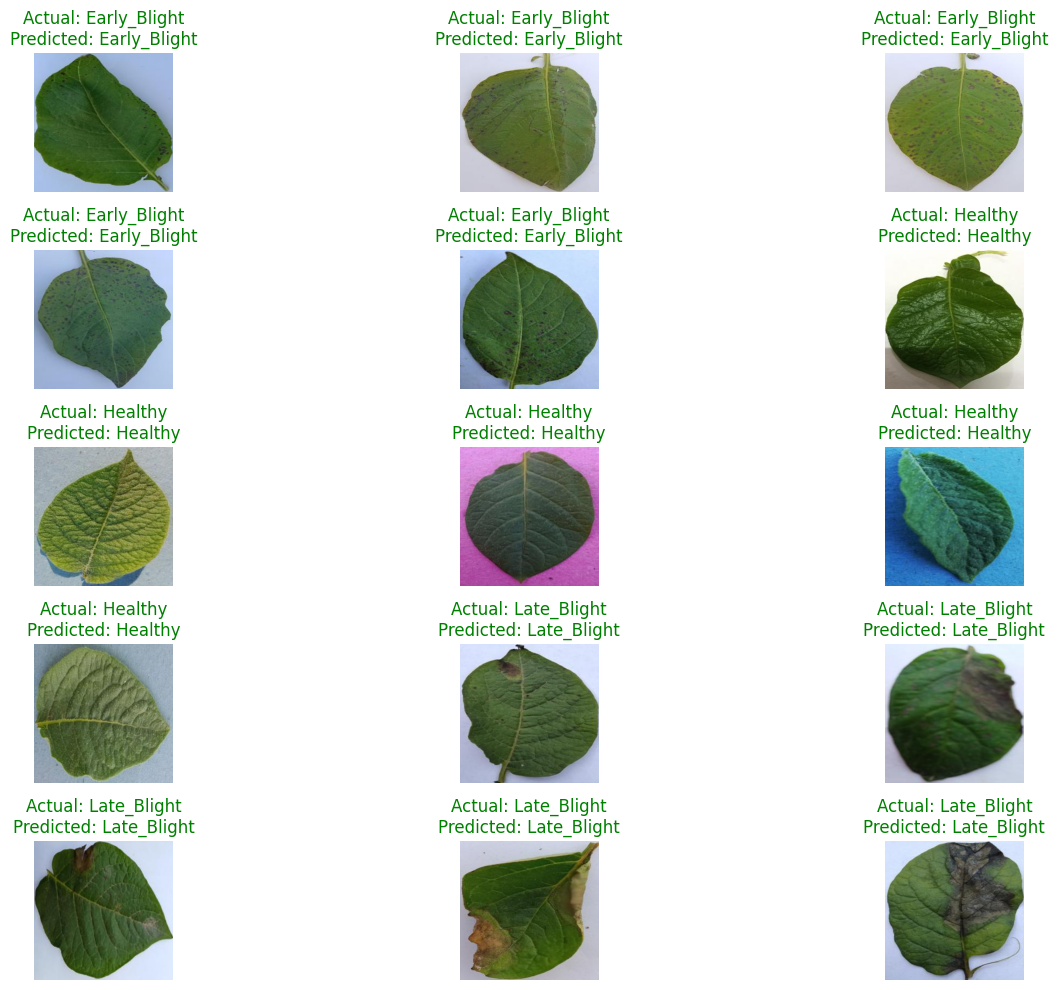

In [ ]:
model_test = premodel
dataset_path = "/content/PLD_3_Classes_256/Testing"
class_labels = ["Early_Blight", "Healthy", "Late_Blight"]

selected_images = []
actual_labels = []

for class_name in class_labels:
    class_dir = os.path.join(dataset_path, class_name)

    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if len(images) < 5:
        print(f"Warning: Only {len(images)} images found in {class_name}, using all available images.")

    selected_images.extend(random.sample(images, min(5, len(images))))
    actual_labels.extend([class_name] * min(5, len(images)))

plt.figure(figsize=(15, 10))

for i, img_path in enumerate(selected_images):
    predicted_label = predict_image(img_path)

    try:
        img = image.load_img(img_path)
        plt.subplot(5, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        title_color = 'green' if predicted_label == actual_labels[i] else 'red'
        plt.title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_label}", color=title_color)

    except Exception as e:
        print(f"Error displaying image {img_path}: {e}")

plt.tight_layout()
plt.show()